In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import os

In [3]:
os.listdir('data')

['mit1002_refseq_rast.mdl',
 'mit1002_refseq_rast.mdl.gf_lb',
 'mit1002_refseq_rast.mdl.gf_min_glc',
 'zip files']

In [5]:
eggnog_excel_fpath = os.path.join('data', 'MIT1002_eggnog_data_20250220_035618.xlsx')
initial_model_fpath = os.path.join('data', 'mit1002_refseq_rast.mdl', 'mit1002_refseq_rast.mdl.xls')
final_model_glc_minimal_fpath = os.path.join('data', 'mit1002_refseq_rast.mdl.gf_min_glc', 'mit1002_refseq_rast.mdl.xls')
final_model_LB_fpath = os.path.join('data', 'mit1002_refseq_rast.mdl.gf_lb', 'mit1002_refseq_rast.mdl.xls')


In [6]:
df_eggnog = pd.read_excel(eggnog_excel_fpath)

In [7]:
df_eggnog = df_eggnog.dropna(subset='query', ).copy()

In [8]:
df_eggnog.KBase_rxns_draft

0       ["rxn05294_c0"]
1       ["rxn05294_c0"]
2                    []
3       ["rxn05294_c0"]
4                    []
             ...       
3924                 []
3925                 []
3926                 []
3927                 []
3928                 []
Name: KBase_rxns_draft, Length: 3929, dtype: object

In [9]:
import ast
def _liststr_to_str(x):
    if x is np.NaN:
        return ''
    #print(x)
    x1 = ast.literal_eval(x)
    return ','.join(x1)
df_eggnog['KBase_rxns_draft'] = df_eggnog.KBase_rxns_draft.apply(_liststr_to_str)

In [10]:
def find_in_eggnog_df(df_merge, df_eggnog, colname, kbase_colname, haseggnog_str):
    colname_explode = f'{colname}_explode' 
    df_eggnog[colname_explode] = df_eggnog[colname].str.split(',')
    df_eggnog_explode = df_eggnog.explode(column=colname_explode, ignore_index=True) 
    df_eggnog_explode_nodup = df_eggnog_explode.dropna(subset=colname_explode).drop_duplicates(subset=colname_explode)
    df_merge1 = pd.merge(df_merge, df_eggnog_explode_nodup, left_on=kbase_colname, right_on=colname_explode, how='left', )
    df_merge1['Has_Eggnog'] = 'No'
    df_merge1.loc[~df_merge1[colname_explode].isna(), 'Has_Eggnog'] = haseggnog_str
    #display(df_eggnog_explode_nodup[colname_explode].value_counts())
    #display(df_merge1[['Has_Eggnog','is_Gap_Fill', ]].value_counts().reset_index().pivot(index='Has_Eggnog', columns='is_Gap_Fill'))
    return df_merge1

In [11]:
def look_for_eggnog_on_onmatched_reactions(df_merge_matched, df_merge, df_eggnog, colname, kbase_colname, haseggnog_str ):
    rxn_without_match = df_merge_matched.loc[df_merge_matched.Has_Eggnog.isin(['No']), 'ms id']
    df_merge_no_eggnog = df_merge.loc[df_merge['ms id'].isin(rxn_without_match)]
    df_merge_matched_new = find_in_eggnog_df(df_merge_no_eggnog, df_eggnog, colname, kbase_colname, haseggnog_str)
    df_merge_matched_has_eggnog = df_merge_matched.loc[~df_merge_matched['ms id'].isin(rxn_without_match)]
    return df_merge_matched_has_eggnog, df_merge_matched_new

In [12]:
def compare_2_models(initial_model_fpath, final_model_fpath, df_eggnog):
    df_init = pd.read_excel(initial_model_fpath, sheet_name='ModelReactions')
    df_final = pd.read_excel(final_model_fpath, sheet_name='ModelReactions')    
    df_merge = pd.merge(df_final, df_init[['id', 'direction']], on='id', how='left', suffixes=['_final', '_init'])
    df_merge['is_Gap_Fill'] = 'No'
    df_merge.loc[df_merge.direction_init != df_merge.direction_final, 'is_Gap_Fill'] = 'Direction'
    df_merge.loc[df_merge.direction_init.isna(), 'is_Gap_Fill'] = 'Yes'
    df_merge_matched_1 = find_in_eggnog_df(df_merge, df_eggnog, 'Manual_ModelSeed_rxn_ID', 'ms id', 'ModelSeed RXN')
    df_merge_matched_has_eggnog_1, df_merge_matched_2 = look_for_eggnog_on_onmatched_reactions(
        df_merge_matched_1, df_merge, df_eggnog, 'KBase_rxns_draft', 'id', 'ModelSeed RXN')
    df_merge_matched_has_eggnog_2, df_merge_matched_3 = look_for_eggnog_on_onmatched_reactions(
        df_merge_matched_2, df_merge, df_eggnog, 'KEGG_Reaction', 'kegg id', 'KEGG RXN')

    df_merge_final = pd.concat([
        df_merge_matched_has_eggnog_1,
        df_merge_matched_has_eggnog_2,
        df_merge_matched_3,
    ], ignore_index=True)
    
    first_cols = ['id','is_Gap_Fill','Has_Eggnog']
    cols = first_cols + [c for c in df_merge_final.columns if c not in first_cols]
    display(df_merge_final[['Has_Eggnog','is_Gap_Fill', ]].value_counts().reset_index().pivot(index='Has_Eggnog', columns='is_Gap_Fill').fillna(0))
    
    return df_merge_final[cols]

In [46]:
df_merge_glc_min =  compare_2_models(initial_model_fpath, final_model_glc_minimal_fpath, df_eggnog)
df_merge_glc_min.to_excel('MIT1002_refseq_GF_glc_min_reactions_with_eggnog.xlsx', index=False)


count      
is_Gap_Fill       No   Yes
Has_Eggnog                
KEGG RXN        20.0   0.0
ModelSeed RXN  987.0   5.0
No             241.0  27.0

In [47]:
df_merge_lb =  compare_2_models(initial_model_fpath, final_model_LB_fpath, df_eggnog)
df_merge_lb.to_excel('MIT1002_refseq_GF_lb_reactions_with_eggnog.xlsx', index=False)


count      
is_Gap_Fill       No   Yes
Has_Eggnog                
KEGG RXN        20.0   0.0
ModelSeed RXN  987.0   6.0
No             241.0  25.0

In [37]:
df_merge_lb_shared_mask = df_merge_lb['ms id'].isin(df_merge_glc_min['ms id'])

df_merge_lb_shared = df_merge_lb.loc[df_merge_lb_shared_mask]
df_merge_lb_unique = df_merge_lb.loc[~df_merge_lb_shared_mask]


In [38]:
df_merged_lb_glc_share = pd.merge(df_merge_glc_min, df_merge_lb_shared[['ms id', 'is_Gap_Fill']], on='ms id', how='left', suffixes=['_glc_min', '_LB'])

In [39]:
df_merged_lb_glc_share['is_Gap_Fill_LB'] = df_merged_lb_glc_share['is_Gap_Fill_LB'].fillna('N/A') 



In [40]:
df_merge_lb_unique =df_merge_lb_unique.rename(columns={'is_Gap_Fill' : 'is_Gap_Fill_LB'})
df_merge_lb_unique['is_Gap_Fill_glc_min'] = 'N/A'

In [41]:
first_cols = ['id','is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', 'Has_Eggnog']
df_merged_lb_glc_final = pd.concat([df_merged_lb_glc_share, df_merge_lb_unique])
cols = first_cols + [c for c in df_merged_lb_glc_final.columns if c not in first_cols]
df_merged_lb_glc_final =  df_merged_lb_glc_final[cols]

In [42]:
df_merged_lb_glc_final['Added By'] = (df_merged_lb_glc_final.is_Gap_Fill_glc_min + ',' + df_merged_lb_glc_final.is_Gap_Fill_LB).map({
    'No,No' : 'Draft', 'Yes,Yes' : 'GF (overlap of both)', 'Yes,N/A' : 'GF (unique to GLC)', 'N/A,Yes' : 'GF (unique to LB)',
})

In [43]:
first_cols = ['id','Added By', 'is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', 'Has_Eggnog']
cols = first_cols + [c for c in df_merged_lb_glc_final.columns if c not in first_cols]
df_merged_lb_glc_final =  df_merged_lb_glc_final[cols]
df_merged_lb_glc_final = df_merged_lb_glc_final.reset_index()

In [44]:
df_merged_lb_glc_final.to_excel('MIT1002_refseq_reactions_gapfill_LB_MIN_GLC_with_eggnog.xlsx')


In [45]:
df_merged_lb_glc_final[['Added By', 'Has_Eggnog']].value_counts(dropna=False).reset_index().pivot(
    index='Has_Eggnog', columns=['Added By'], ).fillna(0)

count                                                          
Added By       Draft GF (overlap of both) GF (unique to GLC) GF (unique to LB)
Has_Eggnog                                                                    
KEGG RXN        20.0                  0.0                0.0               0.0
ModelSeed RXN  987.0                  5.0                0.0               1.0
No             241.0                 21.0                6.0               4.0

In [24]:
df_merged_lb_glc_final[['is_Gap_Fill_glc_min', 'is_Gap_Fill_LB', ]].value_counts(dropna=False).reset_index().pivot(
    index='is_Gap_Fill_LB', columns=['is_Gap_Fill_glc_min',], ).fillna(0)

count              
is_Gap_Fill_glc_min   N/A      No   Yes
is_Gap_Fill_LB                         
N/A                   0.0     0.0   6.0
No                    0.0  1248.0   0.0
Yes                   5.0     0.0  26.0

In [25]:
df_merge_glc_min.is_Gap_Fill.value_counts(dropna=False), df_merged_lb_glc_final.is_Gap_Fill_glc_min.value_counts(dropna=False)

(is_Gap_Fill
 No     1248
 Yes      32
 Name: count, dtype: int64,
 is_Gap_Fill_glc_min
 No     1248
 Yes      32
 N/A       5
 Name: count, dtype: int64)

In [26]:
df_merge_lb.is_Gap_Fill.value_counts(dropna=False), df_merged_lb_glc_final.is_Gap_Fill_LB.value_counts(dropna=False)

(is_Gap_Fill
 No     1248
 Yes      31
 Name: count, dtype: int64,
 is_Gap_Fill_LB
 No     1248
 Yes      31
 N/A       6
 Name: count, dtype: int64)

In [27]:
df_merged_lb_glc_final['is_Gap_Fill_glc_min'].value_counts(dropna=False)

is_Gap_Fill_glc_min
No     1248
Yes      32
N/A       5
Name: count, dtype: int64

In [28]:
df_merged_lb_glc_final_explode = df_merged_lb_glc_final.copy()
df_merged_lb_glc_final_explode['kegg pathway'] = df_merged_lb_glc_final_explode['kegg pathways'].str.split('|')
df_merged_lb_glc_final_explode = df_merged_lb_glc_final_explode.explode('kegg pathway')


In [29]:
df_merged_lb_glc_final_explode['kegg pathway'].unique()

array(['Folate biosynthesis', 'Glutathione metabolism',
       'Valine, leucine and isoleucine degradation',
       'Cysteine and methionine metabolism', 'Sulfur metabolism',
       'Pyrimidine metabolism', 'Peptidoglycan biosynthesis',
       'Glycolysis / Gluconeogenesis', 'Citrate cycle (TCA cycle)',
       'Pyruvate metabolism',
       'Carbon fixation in photosynthetic organisms',
       'Streptomycin biosynthesis', 'Polyketide sugar unit biosynthesis',
       'Fatty acid elongation', 'Fatty acid degradation',
       'Vitamin B6 metabolism', 'Arginine and proline metabolism',
       'Glycine, serine and threonine metabolism', 'Purine metabolism',
       'Alanine, aspartate and glutamate metabolism',
       'Pantothenate and CoA biosynthesis',
       'Pentose and glucuronate interconversions',
       'Ascorbate and aldarate metabolism',
       'Starch and sucrose metabolism',
       'Amino sugar and nucleotide sugar metabolism',
       'Benzoate degradation', nan, 'Galactose metabo

In [30]:
df_merged_lb_glc_final_explode = df_merged_lb_glc_final_explode.reset_index(drop=True)

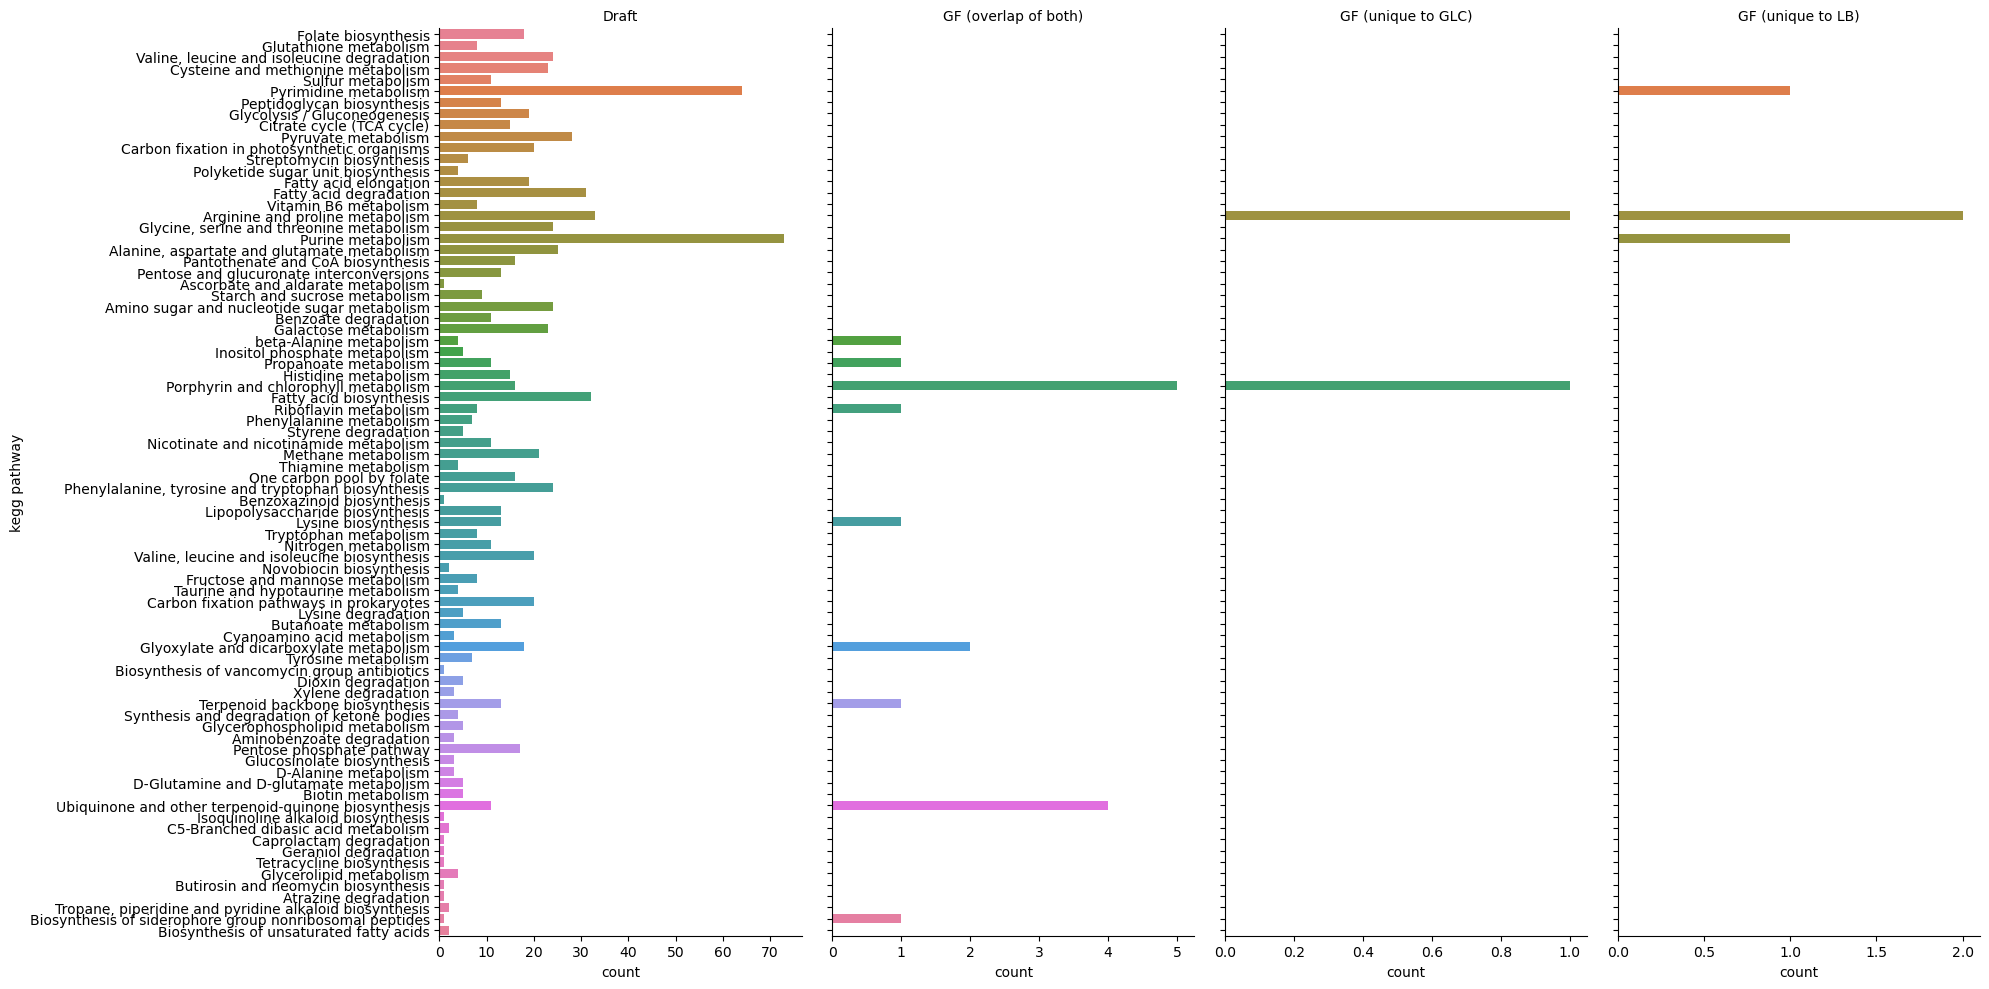

In [31]:
sns.catplot(
    data=df_merged_lb_glc_final_explode,
    col='Added By', y='kegg pathway', kind='count',
    sharex=False, 
    height=10, aspect=0.5,
    hue='kegg pathway', legend=False,
).set_titles(col_template='{col_name}')


Text(0.5, 1.03, 'MIT1002 (from refseq) Gapfilling')

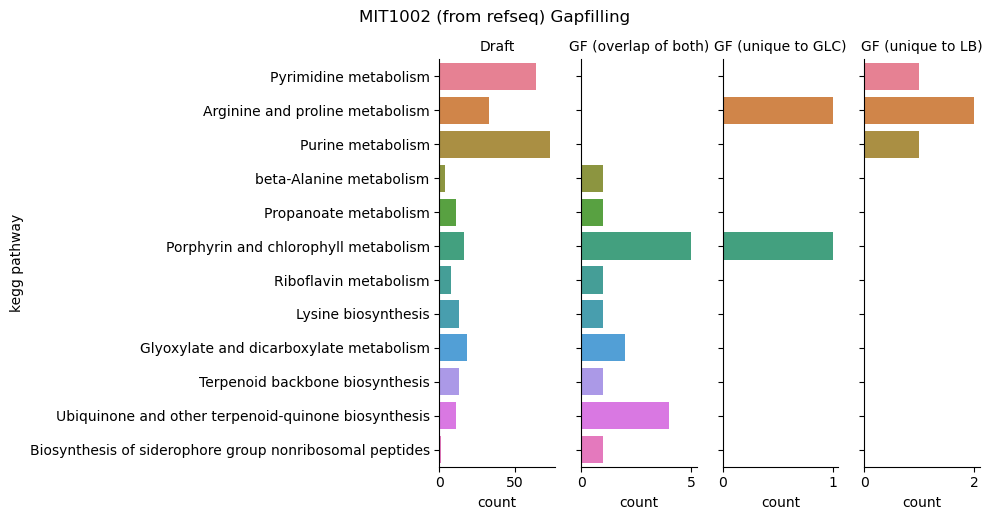

In [34]:
interesting_keggs = df_merged_lb_glc_final_explode.loc[~df_merged_lb_glc_final_explode['Added By'].isin(['Draft']), 'kegg pathway']
sns.catplot(
    data=df_merged_lb_glc_final_explode.loc[df_merged_lb_glc_final_explode['kegg pathway'].isin(interesting_keggs)],
    col='Added By', y='kegg pathway', kind='count',
    sharex=False, 
    #height=10, 
    aspect=0.5,
    hue='kegg pathway', legend=False,
).set_titles(col_template='{col_name}')
plt.suptitle('MIT1002 (from refseq) Gapfilling', y=1.03)

# exploration

In [27]:
df_init = pd.read_excel(initial_model_fpath, sheet_name='ModelReactions')
df_final = pd.read_excel(final_model_fpath, sheet_name='ModelReactions')

In [29]:
df_merge = pd.merge(df_final, df_init, on='id', how='outer', suffixes=['_final', '_init'])

In [30]:
# gap fill reactions

In [31]:
df_merge.loc[df_merge.direction_init.isna()]

,id,direction_final,compartment_final,gpr_final,name_final,enzyme_final,deltag_final,reference_final,equation_final,definition_final,...,enzyme_init,deltag_init,reference_init,equation_init,definition_init,ms id_init,bigg id_init,kegg id_init,kegg pathways_init,metacyc pathways_init
767,rxn03408_c0,>,Cytosol,Unknown,UDP-N-acetyl-D-glucosamine:undecaprenyl-diphos...,NaN,-1.70,NaN,(1) cpd00037[c0] + (1) cpd03494[c0] -> (1) ...,(1) UDP-N-acetylglucosamine [c0][c0] + (1) U...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,rxn00359_c0,<,Cytosol,Unknown,3'-phosphoadenylyl-sulfate sulfohydrolase,3.6.2.2,-30.34,NaN,(1) cpd00001[c0] + (1) cpd00044[c0] <- (1) ...,(1) H2O [c0][c0] + (1) 3-phosphoadenylylsulf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,rxn12008_c0,<,Cytosol,Unknown,R05611,NaN,22.53,NaN,(1) cpd00012[c0] + (1) cpd00067[c0] + (1) c...,(1) PPi [c0][c0] + (1) H+ [c0][c0] + (1) Fa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,rxn08333_c0,>,Cytosol,Unknown,"1,4-dihydroxy-2-naphthoate octaprenyltransferase",NaN,10.17,NaN,(1) cpd02295[c0] + (1) cpd02557[c0] -> (1) ...,(1) 1-4-Dihydroxy-2-naphthoate [c0][c0] + (1)...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,rxn02898_c0,>,Cytosol,Unknown,"O-Succinylbenzoyl-CoA 1,4-dihydroxy-2-naphthoa...",NaN,-14.27,NaN,(1) cpd02021[c0] -> (1) cpd00010[c0] + (1) ...,(1) Succinylbenzoyl-CoA [c0][c0] -> (1) CoA ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,rxn10421_c0,>,Cytosol,Unknown,4-Aminobenzoate mitochondrial transport via sy...,NaN,0.00,NaN,(1) cpd00067[e0] + (1) cpd00443[e0] -> (1) ...,(1) H+ [e0][e0] + (1) ABEE [e0][e0] -> (1) ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950,rxn05645_c0,>,Cytosol,Unknown,riboflavin transport in via proton symport,NaN,0.00,NaN,(1) cpd00067[e0] + (1) cpd00220[e0] -> (1) ...,(1) H+ [e0][e0] + (1) Riboflavin [e0][e0] ->...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
951,rxn01792_c0,>,Cytosol,Unknown,Pantothenate amidohydrolase,3.5.1.22,-0.46,NaN,(1) cpd00001[c0] + (1) cpd00644[c0] -> (1) ...,(1) H2O [c0][c0] + (1) PAN [c0][c0] -> (1) ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
952,rxn01396_c0,>,Cytosol,Unknown,ATP:pyridoxine 5'-phosphotransferase,NaN,-14.03,NaN,(1) cpd00002[c0] + (1) cpd00263[c0] -> (1) ...,(1) ATP [c0][c0] + (1) Pyridoxol [c0][c0] ->...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# removed reactions
df_merge.loc[df_merge.direction_final.isna()]


,id,direction_final,compartment_final,gpr_final,name_final,enzyme_final,deltag_final,reference_final,equation_final,definition_final,...,enzyme_init,deltag_init,reference_init,equation_init,definition_init,ms id_init,bigg id_init,kegg id_init,kegg pathways_init,metacyc pathways_init


In [37]:
# column changes
tmp_df_merge =df_merge.loc[~df_merge.direction_init.isna()].copy()
tmp_df_merge = tmp_df_merge.fillna('NA')
for c in df_init.columns:
    if c == 'id':
        continue
    changed_values = tmp_df_merge.loc[tmp_df_merge[f'{c}_init'] != tmp_df_merge[f'{c}_final']]
    print(c, changed_values.shape[0])

direction 0
compartment 0
gpr 72
name 0
enzyme 0
deltag 0
reference 0
equation 0
definition 0
ms id 0
bigg id 0
kegg id 0
kegg pathways 0
metacyc pathways 0


In [38]:
c='gpr'
changed_values = tmp_df_merge.loc[tmp_df_merge[f'{c}_init'] != tmp_df_merge[f'{c}_final']]
changed_values[[f'{c}_init',f'{c}_final']]

,gpr_init,gpr_final
2,(1933_gene and 1934_gene),(1934_gene and 1933_gene)
20,(1352_gene or 2496_gene or 3042_gene or 967_gene),(2496_gene or 3042_gene or 1352_gene or 967_gene)
21,(684_gene or 685_gene or 686_gene),(686_gene or 685_gene or 684_gene)
30,(1866_gene and 1865_gene and 1868_gene and 186...,(1867_gene and 1865_gene and 1866_gene and 186...
66,(1607_gene or (1247_gene or 1682_gene)),(1607_gene or (1682_gene or 1247_gene))
...,...,...
694,(3503_gene and 3504_gene),(3504_gene and 3503_gene)
695,(2050_gene and 2054_gene and 643_gene and 2052...,(2052_gene and 2054_gene and 2055_gene and 643...
696,(3503_gene and 3504_gene),(3504_gene and 3503_gene)
698,(4027_gene and 4028_gene and 4028_gene),(4028_gene and 4027_gene and 4028_gene)


In [92]:
import ast
df_eggnog.KBase_rxns_draft.apply(ast.literal_eval)

0       [rxn05294_c0]
1       [rxn05294_c0]
2                  []
3       [rxn05294_c0]
4                  []
            ...      
3924               []
3925               []
3926               []
3927               []
3928               []
Name: KBase_rxns_draft, Length: 3929, dtype: object